(hierarchical_linregr)=
# Part II: Hierarchical Sampling

In this section, we demonstrate how to obtain estimates for the model parameters $m_0$, $m_1$, $m_2$, and $m_3$ while treating the data noise as a free parameter, to be inferred from the data. If you haven't already, we recommend reviewing [Part I: Known Data Noise](simple_linregr), which provides a detailed explanation of the code needed to define and solve a simple regression problem.

## Import libraries and define constants

In [1]:
import bayesbay as bb
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(30)

In [2]:
# dimensions and true coefficients
N_DIMS = 4
M0, M1, M2, M3 = 20, -10, -3, 1

# data and noise
N_DATA = 15
DATA_X = np.linspace(-5, 10, N_DATA)
DATA_NOISE_STD = 20

## Data predictions and kernel

In [3]:
fwd_operator = np.vander(DATA_X, N_DIMS, True)
y = fwd_operator @ [M0, M1, M2, M3]
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

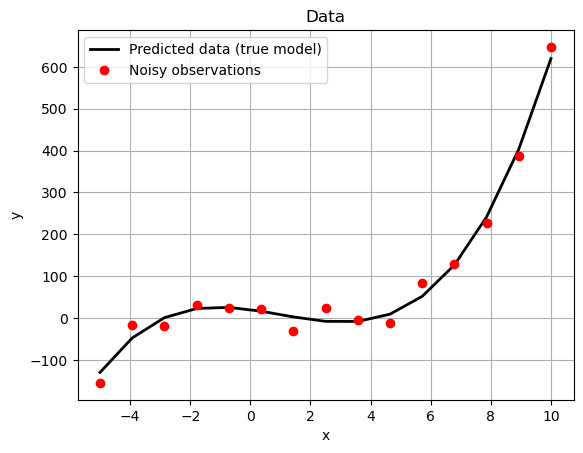

In [4]:
fig, ax = plt.subplots()
ax.set_title('Data')
ax.plot(DATA_X, y, 'k', lw=2, label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

### **1. Prior probability**

In [5]:
m0 = bb.prior.GaussianPrior(name="m0", mean=20, std=1, perturb_std=0.5)
m1 = bb.prior.UniformPrior(name="m1", vmin=-13, vmax=-7, perturb_std=0.4)
m2 = bb.prior.UniformPrior(name="m2", vmin=-10, vmax=4, perturb_std=0.5)
m3 = bb.prior.GaussianPrior(name="m3", mean=1, std=0.1, perturb_std=0.1)

### **2. Parameter space and parameterization**

In [6]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=1, 
    parameters=[m0, m1, m2, m3], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### **3. Forward problem**

In [7]:
def fwd_function(state: bb.State) -> np.ndarray:
    m = [state["my_param_space"][f"m{i}"] for i in range(N_DIMS)]
    return np.squeeze(fwd_operator @ m) # dpred = G m

### **4. Observed data: the Target**

```{important}
In BayesBay, the hyper-parameters related to the data noise should be set up through the data [Target](../api/api_standard_target). This is accomplished by specifying minimum and maximum bounds for the standard deviation of the data and, optionally, for the data correlation.
```
In this instance, we assume that there is no correlation between adjacent data points.

In [8]:
target = bb.Target("my_data", 
                   y_noisy, 
                   std_min=0, 
                   std_max=40, 
                   std_perturb_std=4,
                   noise_is_correlated=False)

### **5. Log Likelihood**

In [9]:
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=fwd_function)

## Run the Bayesian sampling

In [10]:
inversion = bb.BayesianInversion(
    log_likelihood=log_likelihood, 
    parameterization=parameterization, 
    n_chains=10
)
inversion.run(
    n_iterations=50_000, 
    burnin_iterations=20_000, 
    save_every=100, 
    verbose=False, 
)

## Retrieve the results and plot

In the following block, we plot all the saved predicted data along with their median (left) and a histogram of the data standard deviation as inferred from the observations (right). With an average of $\sim$16.5, the inferred data noise is slightly underestimated in this case, yet it falls close to the true noise standard deviation of 20 that was used to generate the synthetic data.

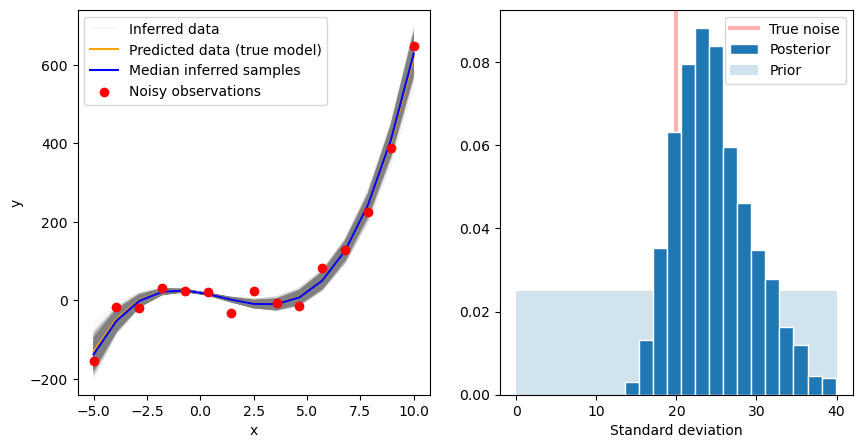

In [11]:
results = inversion.get_results()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
y_pred = np.array(results["my_data.dpred"])
ax1.plot(DATA_X, y_pred[0], c='gray', lw=0.3, alpha=0.3, label="Inferred data")
ax1.plot(DATA_X, y_pred[1:].T, c='gray', lw=0.3, alpha=0.3)
ax1.plot(DATA_X, y, c='orange', label='Predicted data (true model)')
ax1.plot(DATA_X, np.median(y_pred, axis=0), c="blue", label='Median inferred samples')
ax1.scatter(DATA_X, y_noisy, c='r', label='Noisy observations', zorder=3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()

ax2.axvline(x=DATA_NOISE_STD, color='r', lw=3, alpha=0.3, label='True noise')
pdf, bins, _ = ax2.hist(results['my_data.std'], density=True, bins=15, ec='w', zorder=100, label='Posterior')
ax2.fill_between([target.std_min, target.std_max], 1 / (target.std_max - target.std_min), alpha=0.2, label='Prior')
ax2.set_xlabel('Standard deviation')
ax2.legend()
plt.show()

Finally, we create a figure that displays the inferred polynomial coefficients, with yellow dots indicating the true values. This is achieved using the [ArviZ](https://python.arviz.org/en/latest/index.html) library, which provides useful functionalities for plotting inference results.

/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (3000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


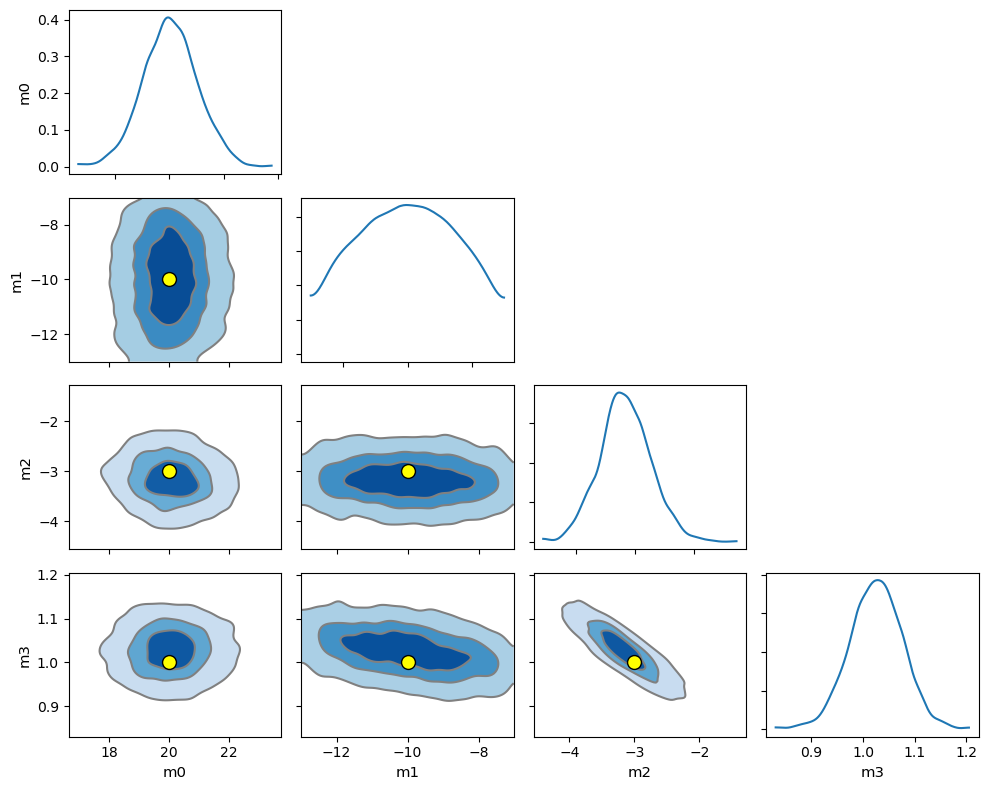

In [12]:
import arviz as az

fig, axes = plt.subplots(4, 4, figsize=(10, 8))
samples = {f'm{i}': results[f'my_param_space.m{i}'] for i in range(4)}
_ = az.plot_pair(
    samples,
    marginals=True,
    reference_values={'m0': M0, 'm1': M1, 'm2': M2, 'm3': M3},
    reference_values_kwargs={'color': 'yellow',
                             'ms': 10},
    kind='kde',
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        'contourf_kwargs': {'cmap': 'Blues'},
        },
    ax=axes,
    textsize=10
    )
plt.tight_layout()